## Positional Encoding
$$\begin{aligned} PE_{(pos, 2i)} &= \sin\left(\frac{pos}{10000^{2i/d_{model}}}\right) \\PE_{(pos, 2i+1)} &= \cos\left(\frac{pos}{10000^{2i/d_{model}}}\right)\end{aligned}$$

- $pos$: 문장 내에서의 단어 위치 (0, 1, 2, ... Sequence Length)
- $i$: 임베딩 벡터 내의 차원 인덱스 ($0, 1, ..., d_{model}/2$)
- $d_{model}$: 임베딩 벡터의 전체 차원 (예: 512)
- $10000$: 파장(Wavelength)을 조절하기 위한 상수


In [66]:
import torch
import torch.nn as nn

import math
import matplotlib.pyplot as plt

In [3]:
torch.sin(torch.tensor([1]))

tensor([0.8415])

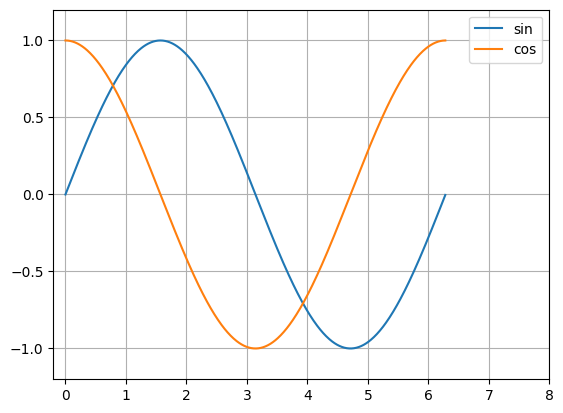

In [22]:
x = torch.arange(0,torch.pi*2, 0.01)
y_sin = torch.sin(x)
y_cos = torch.cos(x)

plt.plot(x, y_sin, label='sin')
plt.plot(x, y_cos, label='cos')
plt.ylim(-1.2,1.2)
plt.xlim(-0.2,8)
plt.grid()
plt.legend(loc='upper right')
plt.show()

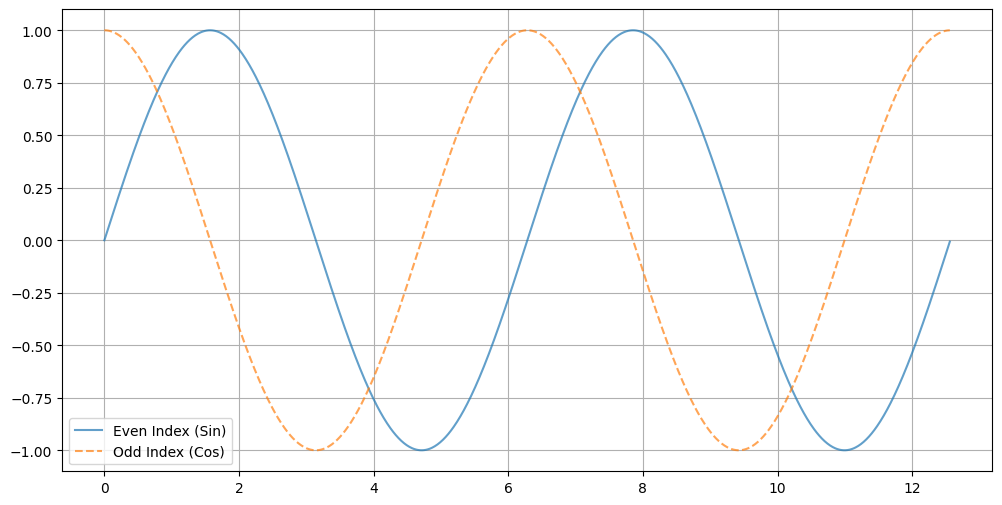

In [28]:
pos = torch.arange(0, torch.pi * 4, 0.01)

pe_even = torch.sin(pos)
pe_odd = torch.cos(pos)
plt.figure(figsize=(12, 6))

plt.plot(pos.numpy(), pe_even.numpy(), label='Even Index (Sin)', alpha=0.7)
plt.plot(pos.numpy(), pe_odd.numpy(), label='Odd Index (Cos)', linestyle='--', alpha=0.7)

plt.legend()
plt.grid(True)
plt.show()

In [ ]:
### 파장에 따른 차이
# 하나의 토큰이 d_model 표현한다고 가정해보면,




In [58]:
# [B, L, dim] 들어옴
# [L, dim]을 이제 positional encoding을 적용해야 한다.
# 그렇다면 0,1,...,L 까지 각각 적용해야 한다.
# 학습은 없다. just encoding


B, L, d_model = 4, 10, 64
x = torch.randn(B, L, d_model)
print(x.shape)

# [L,1]
# 각 행이 몇 번째 토큰인지 의미
pos = torch.arange(L)
pos = pos.unsqueeze(1)
print(pos.shape)

i = torch.arange(d_model//2)
print(i.shape)

div_term = torch.pow(10000, 2*i / d_model)
print(div_term.shape)

# pos: [L,1] div_term: [d_model//2,]
# [L,1] [1,d_model//2]
# [L, d_model//2] [L, d_model//2]
theta = pos / div_term
print(theta.shape)

pe = torch.zeros(L, d_model)
print(pe.shape)
pe[:, 0::2] = torch.sin(theta)
pe[:, 1::2] = torch.cos(theta)
print(pe.shape)

# [B, L, d_model] + [L, d_model] -> [B, L, d_model]
x_with_pe = x + pe.unsqueeze(0)
print(x_with_pe.shape)

diff0 = (x_with_pe[0] - x[0])
diff1 = (x_with_pe[1] - x[1])
print("PE added same across batch:", torch.allclose(diff0, diff1))


torch.Size([4, 10, 64])
torch.Size([10, 1])
torch.Size([32])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10, 64])
torch.Size([10, 64])
torch.Size([4, 10, 64])
PE added same across batch: False


In [61]:
print("max abs diff:", (diff0 - diff1).abs().max().item())
print("mean abs diff:", (diff0 - diff1).abs().mean().item())
torch.allclose(diff0, diff1, atol=1e-6, rtol=1e-5)

max abs diff: 1.7881393432617188e-07
mean abs diff: 2.8579961508512497e-08


True

In [71]:
class PositionalEncoding:
    def __init__(
        self,
        d_model: int,
        max_len: int,
        dropout: float = 0.1,
    ):
        self.d_model = d_model
        self.max_len = max_len
        self.training = True

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        
        div_term = torch.exp(
            torch.arange(0, d_model, 2, dtype=torch.float) * (-math.log(10000.0) / d_model)
        )

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # [max_len, d_model] -> [1, max_len, d_model]
        self.pe = pe.unsqueeze(0)
        self.dropout = Dropout(p=dropout)

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        return self.forward(x)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        seq_len = x.size(1)

        x = x + self.pe[:, :seq_len, :]

        if self.dropout is not None:
            x = self.dropout(x)
        
        return x

    def train(self, mode: bool = True):
        self.training = mode
        self.dropout.train(mode)
        return self
    
    def eval(self):
        return self.train(False)
    
    def parameters(self):
        return []
    
    def zero_grad(self):
        return

    def to(self, device):
        self.pe = self.pe.to(device)
        return self

In [68]:
class Dropout:
    def __init__(
            self,
            p: float
    ):  
        if not (0.0 <= p < 1.0):
            raise ValueError("p must be in [0,1)")
        self.p = p
        self.training = True

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        return self.forward(x)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if not self.training or self.p == 0.0:
            return x
        
        keep_prob = 1.0 - self.p
        mask = torch.rand_like(x) < keep_prob
        
        return (x * mask) / keep_prob

    def train(self, mode: bool=True):
        self.training = mode
        return self
    
    def eval(self):
        self.training = False
        return self.train(False)

In [69]:
# 생성
pe = PositionalEncoding(d_model=512, max_len=100, dropout=0.1)

# 사용
x = torch.randn(2, 50, 512)
output = pe(x)

print(f"Input:  {x.shape}")
print(f"Output: {output.shape}")
print(f"PE:     {pe.pe.shape}")

# Train vs Eval
pe.train()
out1 = pe(x)
pe.eval()
out2 = pe(x)
print(f"Train != Eval: {not torch.equal(out1, out2)}")  # True (dropout 때문)

Input:  torch.Size([2, 50, 512])
Output: torch.Size([2, 50, 512])
PE:     torch.Size([1, 100, 512])
Train != Eval: True
